# Predictive Power of FOMC statements on VIX



# Introduction

In this notebook, we have the following goal: find alpha in statements of FOMC meetings in relation to the VIX index. This will be achieved by using both algorithms seen in class and litterature on the subject.
-how vix is traded
-seasonnal effects of vix (mondays/fridays)...
-other economic statements

# Package Import

Firstly, we look to import the skfin which will be useful for all sort of things, as well as the different other libraries.

In [ ]:
!git clone https://github.com/schampon/skfin.git
%cd skfin
!./create_env.sh

In [152]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from datetime import date
from pathlib import Path

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from skfin.plot import bar, line
from tqdm.auto import tqdm
import yfinance as yf
from collections import Counter
from sklearn.linear_model import LogisticRegression

from skfin.datasets import load_fomc_statements, load_loughran_mcdonald_dictionary
from skfin.plot import line
from skfin.text import coefs_plot, show_text
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from pandas.tseries.offsets import BDay
from skfin.datasets import load_kf_returns
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.pipeline import Pipeline

from skfin.datasets import load_fomc_change_date
import matplotlib.cm as cm
from sklearn.decomposition import NMF, PCA

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor,GradientBoostingClassifier
from sklearn.svm import SVR


from functools import reduce
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data Overview

For this project, we elect to use the Loughran-Mcdonald dictionary in a first instance to measure the overall sentiment of FOMC statements. Furthermore, we obtain the actual statements from the datasets comprised in skfin. Finally, the actual VIX close index values are retrieved from Yahoo Finance through the yfinance module.

In [3]:
statements = load_fomc_statements()
lm = load_loughran_mcdonald_dictionary()


As mentionned in the introduction, the litterature cites a significantly different impact of unannonced FOMC meeting compared to expected ones. By its very nature, the VIX index is heavely dependant on market conditions (...?) and thus our study of the impact of FOMC meetings would benefit greatly from excluding unscheduled meetings from our dataset as these mostly appear in extraordianry circumstances. These could potentially hold a lot of alpha in terms of vocabulary used as...(continue).

In [9]:
Counter([x.year for x in statements.index])

Counter({1999: 6,
         2000: 8,
         2001: 11,
         2002: 8,
         2003: 8,
         2004: 8,
         2005: 8,
         2006: 8,
         2007: 10,
         2008: 11,
         2009: 8,
         2010: 9,
         2011: 8,
         2012: 8,
         2013: 8,
         2014: 8,
         2015: 8,
         2016: 8,
         2017: 8,
         2018: 8,
         2019: 9,
         2020: 12,
         2021: 8,
         2022: 8,
         2023: 8,
         2024: 1})

We only consider these dates to be excluded as...

In [12]:
# Removing special days
print(len(statements.index))
special_days = ["2008-01-22", "2010-05-09", "2020-03-15"]
idx0 = pd.to_datetime(pd.Index(special_days))
idx = statements.index.difference(idx0)
statements = statements.loc[idx]
print(len(statements.index))

213
210


As for our target feature, we use VIX index data from yfinance. dates of interest...

In [20]:
vix_ticker = "^VIX"

start_date = "1999-01-01"
end_date = "2024-02-01"

vix_data = yf.download(vix_ticker, start=start_date, end=end_date)

vix_returns=pd.DataFrame(vix_data['Close'].pct_change()[1:])

[*********************100%***********************]  1 of 1 completed


#Initial analysis of the problem

Overview of the VIX index

<ipython-input-71-29adb778e500>:10: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o:r" (-> marker='o'). The keyword argument will take precedence.
  axs[2].plot(vix_data["Close"].loc[idx_end.strftime('%Y-%m-%d')], 'o:r', marker="*", ms=5)


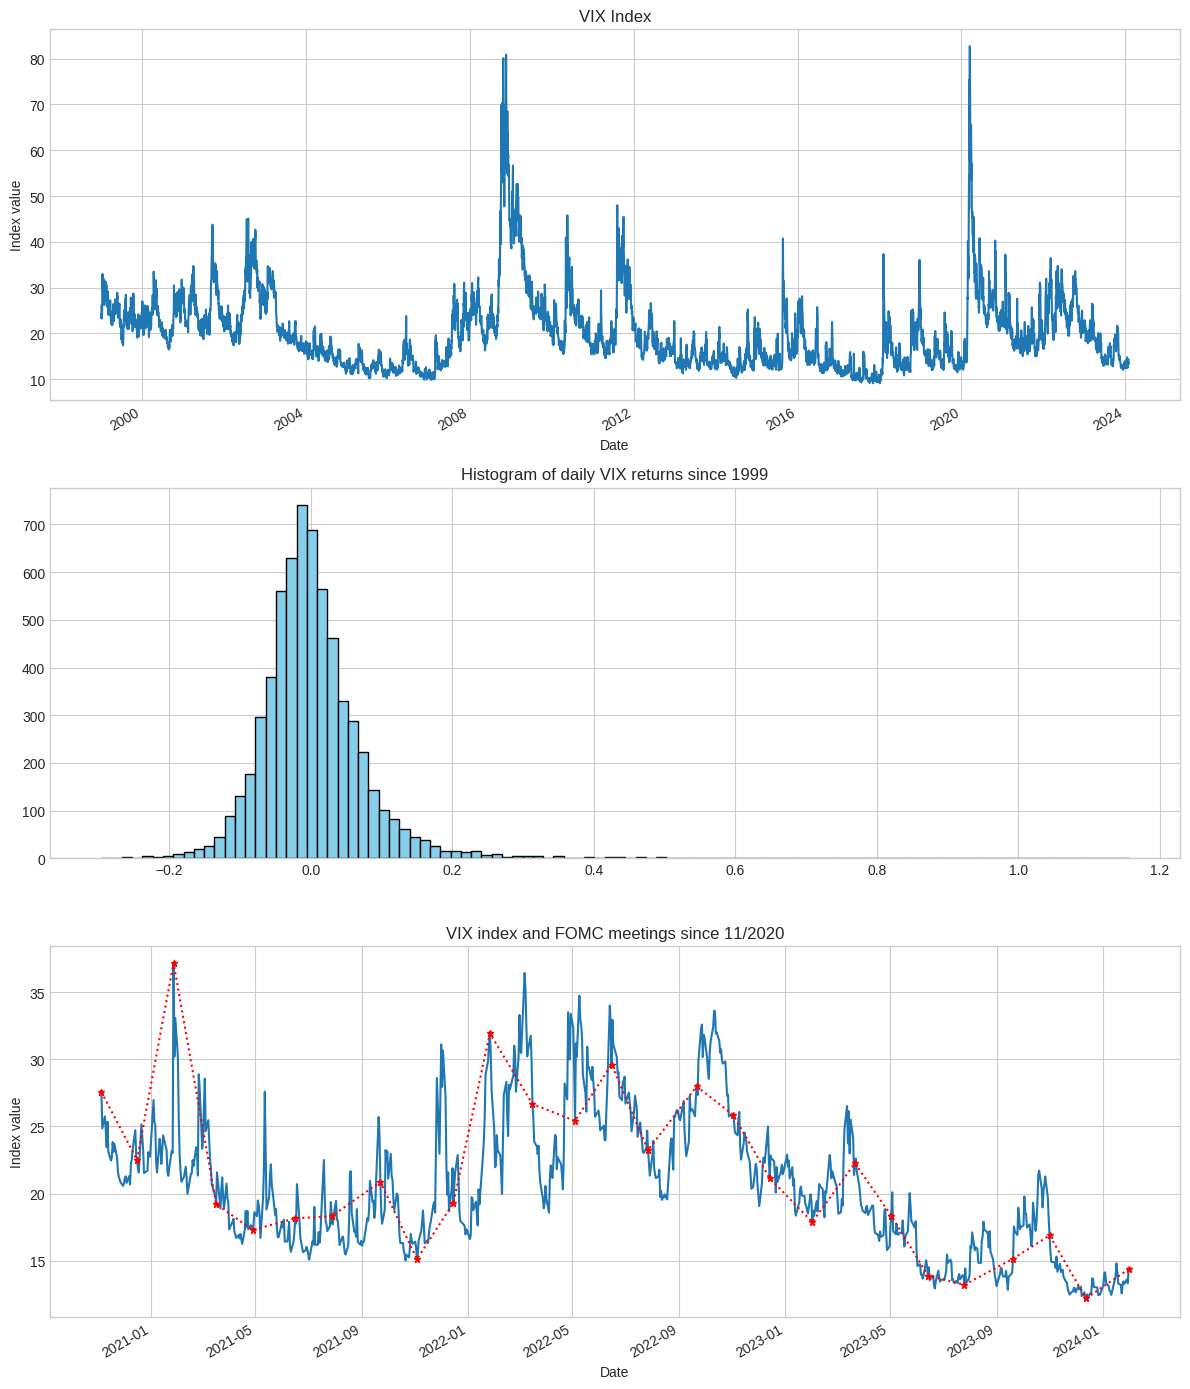

In [71]:
fig, axs = plt.subplots(3, 1, figsize=(12, 14))

vix_data["Close"].plot(title="VIX Index", ylabel="Index value", xlabel="Date", ax=axs[0])

axs[1].hist(np.clip(vix_returns['Close'], -5, 5), color='skyblue', bins = 100, edgecolor='black')
axs[1].set_title('Histogram of daily VIX returns since 1999')

vix_data["Close"][5497:].plot(title="VIX Index", ylabel="Index value", xlabel="Date", ax=axs[2])
idx_end = idx[183:]
axs[2].plot(vix_data["Close"].loc[idx_end.strftime('%Y-%m-%d')], 'o:r', marker="*", ms=5)
axs[2].set_title('VIX index and FOMC meetings since 11/2020')

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Create a figure with 2 rows and 2 columns
fig = plt.figure(figsize=(8, 6))

# Plot on the first subplot (top-left)
plt.subplot2grid((2, 2), (0, 0))
plt.plot([0, 1, 2], [0, 1, 0])
plt.title('(0, 0)')

# Plot on the second subplot (top-right)
plt.subplot2grid((2, 2), (0, 1))
plt.plot([0, 1, 2], [1, 0, 1])
plt.title('(0, 1)')

# Plot on the third subplot (bottom, spans 2 columns)
plt.subplot2grid((2, 2), (1, 0), colspan=2)
plt.plot([0, 1, 2], [0, 1, 1])
plt.title('(1, 0) and (1, 1)')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


Whaley (2008) explains that the VIX historically follows mean-reverting tendencies, which is not disproved by the overall flat forward of the index, and the profil of its returns : slightly skewed negatively but with a fatter tail on the positive side. Phrase graphe 3-> extremum local mais pas tt le temps...

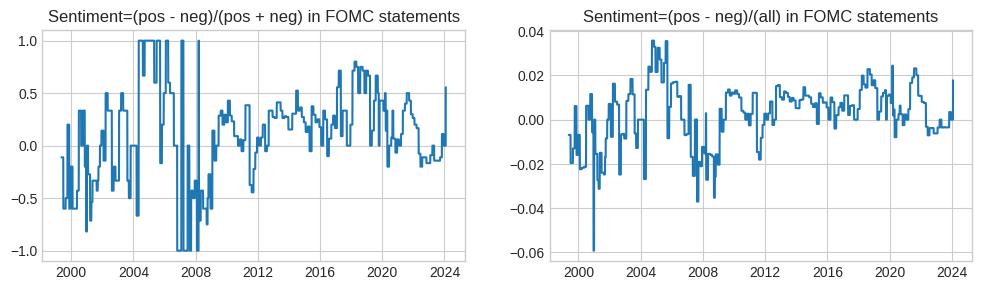

In [78]:
# First analysis
# Find the negative and positive words in the statements

X = statements["text"]

funcs = {
    "negative": lambda x: x.Negative > 0,
    "positive": lambda x: x.Positive > 0,
    "all": lambda x: x.Word.notna(),
}

def get_total_count(X, lm, func):
    m = CountVectorizer(vocabulary=lm.loc[func].Word.str.lower().values)
    return pd.DataFrame(m.fit_transform(X).toarray(), index=X.index).sum(axis=1)

lm_counts = pd.concat({k: get_total_count(X, lm, v) for k, v in funcs.items()}, axis=1)

# This cell will show the negative (red) and positive (green) words in each statement
# and will plot the evolution of the sentiment in the FOMC statements throughout the years

fig, axs = plt.subplots(1, 2, figsize=(12, 3))

line(
    lm_counts.pipe(lambda x: (x.positive - x.negative) / (x.positive + x.negative))
    .resample("B")
    .last()
    .ffill(),
    legend=False,
    title="Sentiment=(pos - neg)/(pos + neg) in FOMC statements",
    ax=axs[0]
)

line(
    lm_counts.pipe(lambda x: (x.positive - x.negative) / x["all"])
    .resample("B")
    .last()
    .ffill(),
    legend=False,
    title="Sentiment=(pos - neg)/(all) in FOMC statements",
    ax=axs[1]
)

In [74]:
print((vix_returns['Close']).corr(lm_counts.pipe(lambda x: (x.positive - x.negative) / x["all"])))
print((vix_returns['Close']).corr(lm_counts.pipe(lambda x: (x.positive - x.negative) / (x.positive + x.negative))))

0.04553717105514023
0.04952287593923554


<Axes: >

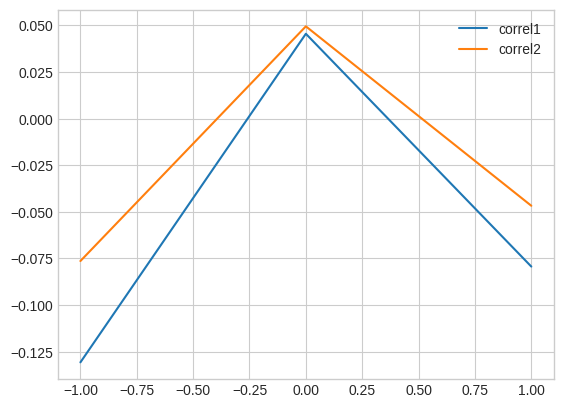

In [82]:
range_ = 1
sent1 = lm_counts.pipe(lambda x: (x.positive - x.negative) / x["all"])
sent2 = lm_counts.pipe(lambda x: (x.positive - x.negative) / (x.positive + x.negative))
correl1 = []
correl2 = []

lags = [i for i in range(-range_, range_+1)]
for lag in lags:
  correl1.append((vix_returns['Close'].shift(-lag)).corr(sent1))
  correl2.append((vix_returns['Close'].shift(-lag)).corr(sent2))

correl_vix_lag = pd.DataFrame({'correl1': correl1, 'correl2': correl2})
correl_vix_lag.index = lags

correl_vix_lag.plot()

phrase correl sentiments

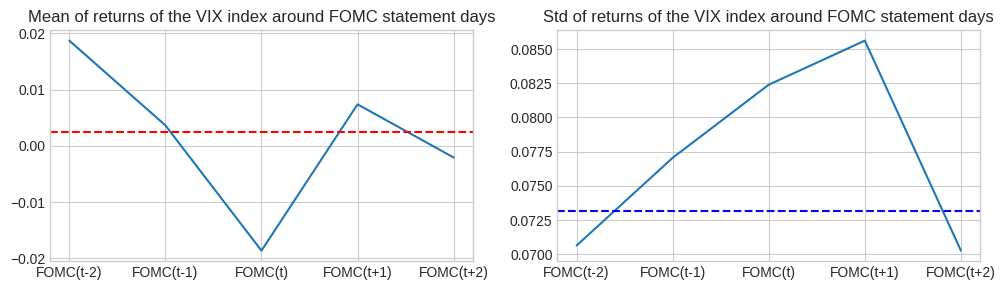

In [112]:
range_ = 2
lags = [i for i in range(-range_, range_+1)]
means = []
stds = []
for lag in lags:
  laged_index = statements.index + pd.tseries.offsets.BDay(lag)
  vix_laged = vix_returns.loc[laged_index.intersection(vix_returns.index)]
  mean = vix_laged.mean()['Close']
  std = vix_laged.std()['Close']
  stds.append(std)
  means.append(mean)


stats_vix_lag = pd.DataFrame({'means': means, 'stds': stds})
stats_vix_lag.index = lags

fig, axs = plt.subplots(1, 2, figsize=(12, 3))

stats_vix_lag['means'].plot(ax=axs[0])
axs[0].axhline(y=vix_returns.mean()['Close'], color='r', linestyle='--',
               label=f'Horizontal Line at {np.round(vix_returns.mean()["Close"], 5)}')
axs[0].set_xticks(lags)
axs[0].set_xticklabels(["FOMC(t-2)", "FOMC(t-1)", "FOMC(t)", "FOMC(t+1)", "FOMC(t+2)"])
axs[0].set_title('Mean of returns of the VIX index around FOMC statement days')

stats_vix_lag['stds'].plot(ax=axs[1])
axs[1].axhline(y=vix_returns.std()['Close'], color='b', linestyle='--',
               label=f'Horizontal Line at {np.round(vix_returns.std()["Close"], 5)}')
axs[1].set_xticks(lags)
axs[1].set_xticklabels(["FOMC(t-2)", "FOMC(t-1)", "FOMC(t)", "FOMC(t+1)", "FOMC(t+2)"])
axs[1].set_title('Std of returns of the VIX index around FOMC statement days')

plt.show()

In the figure above, on the leftmost graph, we can see that VIX returns are indeed negative on FOMC meeting days, significantly lower than the average return across the whole period (represented by the red-dotted line). This validates what was supposed in the introduction: by representing the VIX as the index of uncertainty, on average, a FOMC decision concerning Fed Fund rates brings clarity to investors about the upcoming market, thus bringing the VIX down. It also confirms the U-shape around statements as the returns are on average higher than the mean both before and after the meeting. From the second graph, we can gather that VIX is itself more volatile around FOMC dates, as the standard deviations of the returns are more important around and at FOMC meeting dates (the standard deviation of the whole series is represented by the blue-dotted line). This is very important for our strategy: firstly, this indicates that there could be non-negligable alpha in our study; secondly, this std is at its highest for t+1 returns. Market participants usually react almost instantly to the statements (30 minute window). Intraday data of this sort isn't available to us at this time, only close quotes. Furthermore, if we were to put such a strategy into place, positions taken on the basis of FOMC statement analysis could only be made after the statements. As such, we really are interested in t+1 returns after analysis of FOMC statement at date t. This means that, even though we can't take part in the immediate movement of VIX following the statements, we can still appreciate some mean-reverting on the following day.

# Implementing our strategy

### Modelling

our work focuses essentially on the choice of our returns and on the choice of our target variable.

We first tried to predict returns directly with FOMC statements, using several NLP/ML models. We then constructed the induced strategy by calculating the sharpe of the P&L generated by the prediction. The P&L were calculated as follows:

P&L=Pred Sign * Actual return (between date and date + lag)


We then tried to predict the sign of the returns, and in this case our aim is to predict the VIX trend with the FOMC statements. We've kept the same way of constructing the strategy


In [119]:
vix_returns[['Close']]

,Close
Date,
1999-01-05,-0.065342
1999-01-06,-0.045789
1999-01-07,0.044130
1999-01-08,-0.044727
1999-01-11,0.093643
...,...
2024-01-25,0.023592
2024-01-26,-0.014126
2024-01-29,0.025641


In [126]:
compute_lagged_return2(vix_data,-1)

,Close
Date,
1999-01-05,NaN
1999-01-06,-0.065342
1999-01-07,-0.045789
1999-01-08,0.044130
1999-01-11,-0.044727
...,...
2024-01-25,0.047012
2024-01-26,0.023592
2024-01-29,-0.014126


In [128]:
a = compute_lagged_return(vix_data,5)
print(len(a))

6309


In [161]:
statements.loc[statements.index.isin(a.index)]

,last_update,text,voting,release_time,url
1999-05-18,1999-05-18 14:15:00,"The Federal Reserve released the following statement after today's Federal Open Market Committee meeting: While the FOMC did not take action today to alter the stance of monetary policy, the Committee was concerned about the potential for a buildup of inflationary imbalances that could undermine the favorable performance of the economy and therefore adopted a directive that is tilted toward the possibility of a firming in the stance of monetary policy. Trend increases in costs and core prices have generally remained quite subdued. But domestic financial markets have recovered and foreign economic prospects have improved since the easing of monetary policy last fall. Against the background of already-tight domestic labor markets and ongoing strength in demand in excess of productivity gains, the Committee recognizes the need to be alert to developments over coming months that might indicate that financial conditions may no longer be consistent with containing inflation.",,,https://www.federalreserve.gov/boarddocs/press/general/1999/19990518/
1999-06-30,1999-06-30 00:00:00,"The Federal Open Market Committee today voted to raise its target for the federal funds rate 25 basis points to 5 percent. Last fall the Committee reduced interest rates to counter a significant seizing-up of financial markets in the United States. Since then much of the financial strain has eased, foreign economies have firmed, and economic activity in the United States has moved forward at a brisk pace. Accordingly, the full degree of adjustment is judged no longer necessary. Labor markets have continued to tighten over recent quarters, but strengthening productivity growth has contained inflationary pressures. Owing to the uncertain resolution of the balance of conflicting forces in the economy going forward, the FOMC has chosen to adopt a directive that includes no predilection about near-term policy action. The Committee, nonetheless, recognizes that in the current dynamic environment it must be especially alert to the emergence, or potential emergence, of inflationary forces that could undermine economic growth.",,,https://www.federalreserve.gov/boarddocs/press/general/1999/19990630/
1999-08-24,1999-08-24 00:00:00,"With financial markets functioning more normally, and with persistent strength in domestic demand, foreign economies firming and labor markets remaining very tight, the degree of monetary ease required to address the global financial market turmoil of last fall is no longer consistent with sustained, noninflationary, economic expansion. Today's increase in the federal funds rate, together with the policy action in June and the firming of conditions more generally in U.S. financial markets over recent months, should markedly diminish the risk of rising inflation going forward. As a consequence, the directive the Federal Open Market Committee adopted is symmetrical with regard to the outlook for policy over the near term. In taking the discount rate action, the Federal Reserve Board approved requests submitted by the Boards of Directors of the Federal Reserve Banks of Boston, New York, Philadelphia, Cleveland, Richmond, Atlanta, Chicago, St. Louis, Kansas City, and San Francisco. The discount rate is the interest rate that is charged depository institutions when they borrow from their district Federal Reserve Banks.",,,https://www.federalreserve.gov/boarddocs/press/general/1999/19990824/
1999-10-05,1999-10-05 00:00:00,"The Federal Open Market Committee decided today to leave its target for the federal funds rate unchanged. Strengthening productivity growth has been fostering favorable trends in unit costs and prices, and much recent information suggests that these trends have been sustained. Nonetheless, the growth of demand has continued to outpace that of supply, as evidenced by a decreasing pool of available workers willing to take jobs. In these circumstances, the Fed

In [130]:
a[(a['Close'] < -0.005) | (a['Close'] > 0.005)]

,Close
Date,
1999-01-05,0.103692
1999-01-06,0.071530
1999-01-07,0.095317
1999-01-08,-0.113402
1999-01-12,-0.021888
...,...
2024-01-18,0.023592
2024-01-19,-0.014126
2024-01-22,0.025641


In [142]:
len(idx)

210

In [121]:
def compute_lagged_return2(vix_data,lag):
  """

  gives the lagged returns of the VIX in output.
  For instance, if lag = 1 then, it will give in output the returns of the next day after each statement release
  """
  vix_returns=pd.DataFrame(vix_data['Close'].pct_change()[1:]).shift(-lag)
  special_days = ["2008-01-22", "2010-05-09", "2020-03-15"]
  idx0 = pd.to_datetime(pd.Index(special_days))
  idx = statements.index.difference(idx0)#.union(idx0 + BDay(1))
  #ret_fomc = vix_returns.div(vix_returns.ewm(252).std()).loc[vix_returns.index.intersection(idx)]
  return vix_returns#ret_fomc

In [176]:

def compute_lagged_return(vix_data,lag):
  """

  gives the lagged returns of the VIX in output.
  For instance, if lag = 1 then, it will give in output the returns of the next day after each statement release
  """
  vix_returns=pd.DataFrame(vix_data['Close'].pct_change()[1:]).shift(-lag)
  special_days = ["2008-01-22", "2010-05-09", "2020-03-15"]
  idx0 = pd.to_datetime(pd.Index(special_days))
  idx = statements.index.difference(idx0)#.union(idx0 + BDay(1))
  ret_fomc = vix_returns.div(vix_returns.ewm(252).std()).loc[vix_returns.index.intersection(idx)]
  return ret_fomc

def run_model_continuous(statements,returns,model):
  """

  Predicts the returns with distinct NLP/ML models.

  """
  if model=='ElasticNet':
    est = Pipeline([
        ("tfidf", TfidfVectorizer(
            vocabulary=None,
            ngram_range=(1, 3),
            max_features=300,
            stop_words="english",
            token_pattern=r"\b[a-zA-Z]{3,}\b",
        )),
        ("reg",  ElasticNet(alpha=0.008))
    ])

  elif model=='RF':
    est = Pipeline([
        ("tfidf", TfidfVectorizer(
            vocabulary=None,
            ngram_range=(1, 3),
            max_features=300,
            stop_words="english",
            token_pattern=r"\b[a-zA-Z]{3,}\b",
        )),
        ("reg", RandomForestRegressor(n_estimators=100, random_state=42))
    ])

  elif model=='GBR':
    est = Pipeline([
        ("tfidf", TfidfVectorizer(
            vocabulary=None,
            ngram_range=(1, 3),
            max_features=300,
            stop_words="english",
            token_pattern=r"\b[a-zA-Z]{3,}\b",
        )),
        ("reg", GradientBoostingRegressor(n_estimators=100, random_state=42))
    ])

  elif model=='SVR':
    est = Pipeline([
        ("tfidf", TfidfVectorizer(
            vocabulary=None,
            ngram_range=(1, 3),
            max_features=300,
            stop_words="english",
            token_pattern=r"\b[a-zA-Z]{3,}\b",
        )),
        ("reg", SVR())
    ])

  #returns=returns[(returns['Close'] < -0.05) | (returns['Close'] > 0.05)]
  y=returns["Close"].dropna()
  y_index=y.index
  statements_concerned=statements.loc[statements.index.isin(y_index)]

  X=statements_concerned['text']
  y=y.loc[X.index]

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

  est.fit(X_train, y_train)
  y_pred = est.predict(X_test)

  results=pd.DataFrame(y_test)
  results['pred']=y_pred

  return results


def run_model_binary(statements,returns,model):
  """

  Predicts the sign of the returns with distinct NLP/ML models.

  """
  if model=='ElasticNet':
    est = Pipeline([
        ("tfidf", TfidfVectorizer(
            vocabulary=None,
            ngram_range=(1, 3),
            max_features=300,
            stop_words="english",
            token_pattern=r"\b[a-zA-Z]{3,}\b",
        )),
        ("reg",  ElasticNet(alpha=0.008))
    ])

    # elif model=='LogReg':
    # est = Pipeline([
    #     ("tfidf", TfidfVectorizer(
    #         vocabulary=None,
    #         ngram_range=(1, 3),
    #         max_features=300,
    #         stop_words="english",
    #         token_pattern=r"\b[a-zA-Z]{3,}\b",
    #     )),
    #     ("reg", LogisticRegression(max_iter=5000))
    # ])

  elif model=='RF':
    est = Pipeline([
        ("tfidf", TfidfVectorizer(
            vocabulary=None,
            ngram_range=(1, 3),
            max_features=300,
            stop_words="english",
            token_pattern=r"\b[a-zA-Z]{3,}\b",
        )),
        ("reg", RandomForestRegressor(n_estimators=100, random_state=42))
    ])

  elif model=='GBR':
    est = Pipeline([
        ("tfidf", TfidfVectorizer(
            vocabulary=None,
            ngram_range=(1, 3),
            max_features=300,
            stop_words="english",
            token_pattern=r"\b[a-zA-Z]{3,}\b",
        )),
        ("reg", GradientBoostingRegressor(n_estimators=100, random_state=42))
    ])

  elif model=='SVR':
    est = Pipeline([
        ("tfidf", TfidfVectorizer(
            vocabulary=None,
            ngram_range=(1, 3),
            max_features=300,
            stop_words="english",
            token_pattern=r"\b[a-zA-Z]{3,}\b",
        )),
        ("reg", SVR())
    ])

  elif model=='GBC':
      est = Pipeline([
          ("tfidf", TfidfVectorizer(
              vocabulary=None,
              ngram_range=(1, 3),
              max_features=300,
              stop_words="english",
              token_pattern=r"\b[a-zA-Z]{3,}\b",
          )),
          ("reg", GradientBoostingClassifier())
      ])


  returns=returns[(returns['Close'] < -0.005) | (returns['Close'] > 0.005)]
  y=np.sign(returns["Close"].dropna())
  y_index=y.index
  statements_concerned=statements.loc[statements.index.isin(y_index)]


  X=statements_concerned['text']
  y=y.loc[X.index]

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
  est.fit(X_train, y_train)
  y_pred = est.predict(X_test)

  results=pd.DataFrame(y_test)
  results['pred']=np.sign(y_pred).astype(int)

  return accuracy_score(results['Close'],results['pred']),results

def compute_strategy(results,vix_data,lag):
  """

  Computes the induced strategy and the induces sharpe

  """
  data=pd.merge(results,vix_data['Close'],left_index=True,right_index=True)
  data=pd.merge(data,vix_data['Close'].shift(-lag),left_index=True,right_index=True)

  data.columns=['Sign at t+'f'{lag}','Pred Sign at t+'+f'{lag}','Price at t','Price at t+'+f'{lag}']
  data['return at date t+'+f'{lag}']=(data['Price at t+'+f'{lag}']-data['Price at t'])/data['Price at t']

  data['P&L']=data['Pred Sign at t+'+f'{lag}']*data['return at date t+'+f'{lag}']

  df_sharpe=pd.DataFrame(index=vix_data.index)#index=range(5000)
  #df_sharpe['P&L']=data.reset_index(drop=True)['P&L']
  df_sharpe['P&L']=data['P&L']
  df_sharpe['P&L']=df_sharpe['P&L'].fillna(0)
  sharpe=np.sqrt(252)*df_sharpe['P&L'].mean()/df_sharpe['P&L'].std()
  return data,sharpe

def pnl_graph(data):
  return data['P&L'].cumsum()

<Axes: >

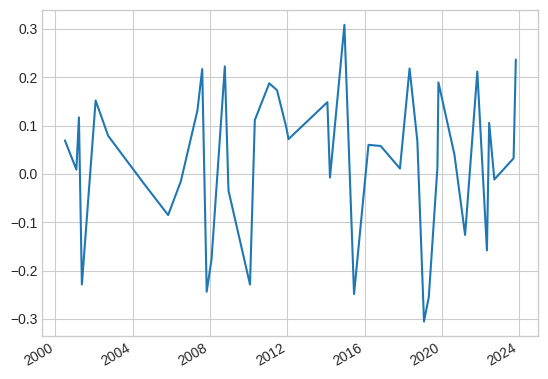

In [179]:
ret_fomc=compute_lagged_return(vix_data,1)
accuracy,results=run_model_binary(statements,ret_fomc,'ElasticNet')
df,sharpe=compute_strategy(results,vix_data,1)
df['P&L'].cumsum().plot()

### Numerical Analysis

In [173]:
# We do it for each lag in [1,30]
models=['ElasticNet']#, 'LogReg']#,'RF','GBR','SVR','GBC']
dfs=[]
for model in models:
  print(model)
  data_binary=[]
  for i in range(1, 2):
    ret_fomc=compute_lagged_return(vix_data,i)
    accuracy,results=run_model_binary(statements,ret_fomc,model)
    df,sharpe=compute_strategy(results,vix_data,i)
    data_binary.append([accuracy,sharpe])

    index=['t+'f'{i}' for i in range(1, 2)]
  final_binary_result=pd.DataFrame(data_binary,columns=['accuracy_'+model,'sharpe_binary_'+model],index=index)
  dfs.append(final_binary_result)
merged_df = reduce(lambda left, right: pd.merge(left,right,left_index=True,right_index=True), dfs)
merged_df#.head()

ElasticNet
[-0.19361391  0.19163639  0.08324499 -0.05705726 -0.24301305 -0.01949582
 -0.12693534 -0.01630246 -0.47827537 -0.07068816  0.00668032  0.01831793
  0.11959493  0.05869981 -0.24926884 -0.17575215  0.02953017 -0.079293
  0.02323308  0.10975484 -0.03113291 -0.05268644  0.02462308  0.10761068
  0.1226724   0.03170734 -0.24882182  0.07419233 -0.17038635  0.04523035
  0.02544399 -0.09124927  0.10167748 -0.03032825  0.06928114 -0.0231936
  0.117562    0.06945146  0.00806335  0.00936576 -0.04572038  0.01698128]
            Close  pred
2002-09-24   -1.0    -1
2019-10-11   -1.0     1
2008-12-16   -1.0     1
2022-09-21   -1.0    -1
2006-06-29    1.0    -1
2017-11-01   -1.0    -1
2004-08-10    1.0    -1
2020-08-27   -1.0    -1
2000-06-28   -1.0    -1
2022-05-04    1.0    -1
2015-06-17   -1.0     1
2021-03-17    1.0     1
2023-09-20    1.0     1
2014-03-19   -1.0     1
2001-01-31   -1.0    -1
2007-10-31    1.0    -1
2019-01-30   -1.0     1
2001-05-15   -1.0    -1
2019-05-01   -1.0     1


,accuracy_ElasticNet,sharpe_binary_ElasticNet
t+1,0.52381,0.024287


In [169]:
vix_data.loc[pd.Timestamp('2002-09-22'):pd.Timestamp('2002-09-26')]['Close']

Date
2002-09-23    39.680000
2002-09-24    40.520000
2002-09-25    37.330002
2002-09-26    34.599998
Name: Close, dtype: float64

In [171]:
statements.index[30]

Timestamp('2002-09-24 00:00:00')

In [ ]:
# We do it for each lag in [1,30]
models=['ElasticNet','RF','GBR','SVR']
index=['t+'f'{i}' for i in range(11)]
dfs_cont=[]
for model in models:
  data_continuous=[]
  for i in range(11):
    ret_fomc=compute_lagged_return(vix_data,i)
    results=run_model_continuous(statements,ret_fomc,model)
    df,sharpe=compute_strategy(results,vix_data,i)
    data_continuous.append(sharpe)
  final_continuous_result=pd.DataFrame(data_continuous,columns=['sharpe_continuous_'+model],index=index)
  dfs_cont.append(final_continuous_result)

merged_df_cont = reduce(lambda left, right: pd.merge(left,right,left_index=True,right_index=True), dfs_cont)
merged_df_cont.head()

,sharpe_continuous_ElasticNet,sharpe_continuous_RF,sharpe_continuous_GBR,sharpe_continuous_SVR
t+1,-0.159199,-0.202215,-0.249052,-0.116264
t+2,0.043153,-0.413466,0.160257,-0.407710
t+3,0.275934,-1.421743,-1.138769,-0.646611
t+4,-0.199891,0.048902,0.306712,0.333734
t+5,-0.847157,-0.609038,-0.415197,0.116383


### Vizualisation

NameError: name 'merged_df_cont' is not defined

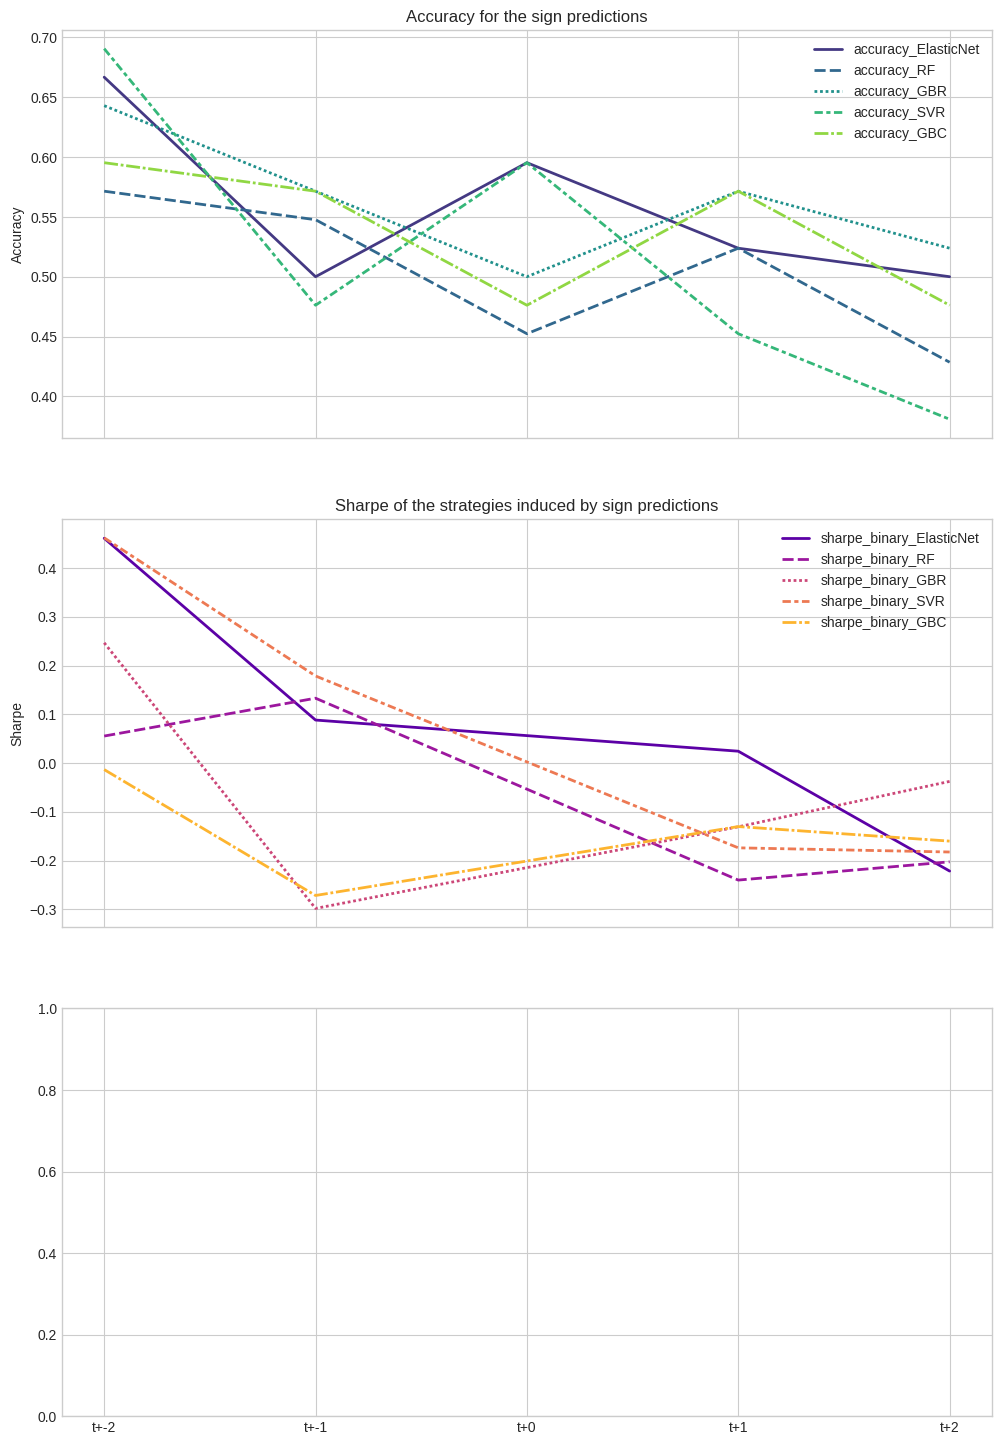

In [141]:
# This cells will plot the evolution of the accuracy (only for the sign prediction)
# and the sharpe induced by each NLP/Model predictions

accuracy_columns = [col for col in merged_df.columns if col.startswith("accuracy")]
sharpe_columns = [col for col in merged_df.columns if col.startswith("sharpe")]
sharpe_cont_columns = sharpe_columns#[col for col in merged_df_cont.columns if col.startswith("sharpe")]

# Create subplots
fig, axes = plt.subplots(3, 1, figsize=(12, 18), sharex=True)

# Plotting Accuracy columns
sns.lineplot(ax=axes[0], data=merged_df[accuracy_columns], palette="viridis", linewidth=2)
axes[0].set_title('Accuracy for the sign predictions')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('prediction lag')

# Plotting Sharpe columns
sns.lineplot(ax=axes[1], data=merged_df[sharpe_columns], palette="plasma", linewidth=2)
axes[1].set_title('Sharpe of the strategies induced by sign predictions')
axes[1].set_ylabel('Sharpe')
axes[1].set_xlabel('prediction lag')

# Plotting Sharpe continuous columns
sns.lineplot(ax=axes[2], data=merged_df_cont[sharpe_cont_columns], palette="coolwarm", linewidth=2)
axes[2].set_title('Sharpe of the strategies induced by returns predictions')
axes[2].set_ylabel('Sharpe')
axes[2].set_xlabel('prediction lag')

# Set common xlabel

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
merged_df.mean()

accuracy_ElasticNet         0.503569
sharpe_binary_ElasticNet   -0.088139
accuracy_RF                 0.478627
sharpe_binary_RF           -0.036552
accuracy_GBR                0.491947
sharpe_binary_GBR          -0.100727
accuracy_SVR                0.508699
sharpe_binary_SVR          -0.030086
accuracy_GBC                0.492776
sharpe_binary_GBC          -0.028276
dtype: float64

In [ ]:
merged_df_cont.mean()

sharpe_continuous_ElasticNet    0.113643
sharpe_continuous_RF           -0.040131
sharpe_continuous_GBR           0.091144
sharpe_continuous_SVR          -0.154057
dtype: float64

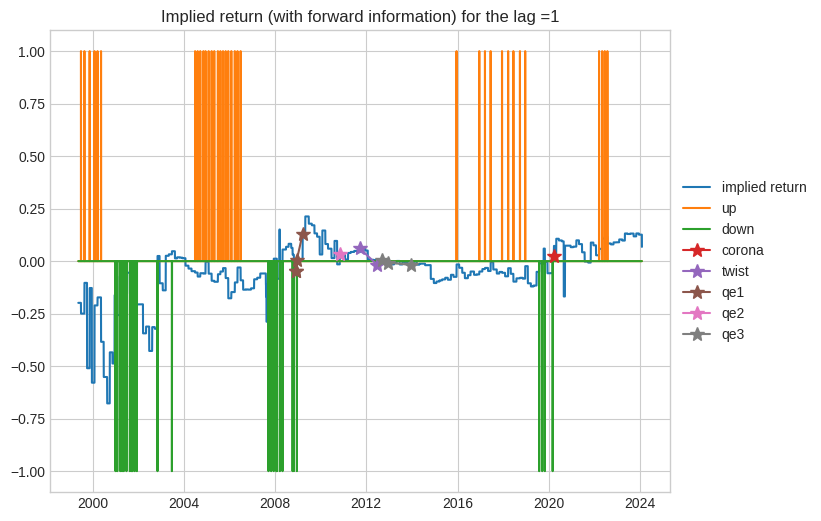

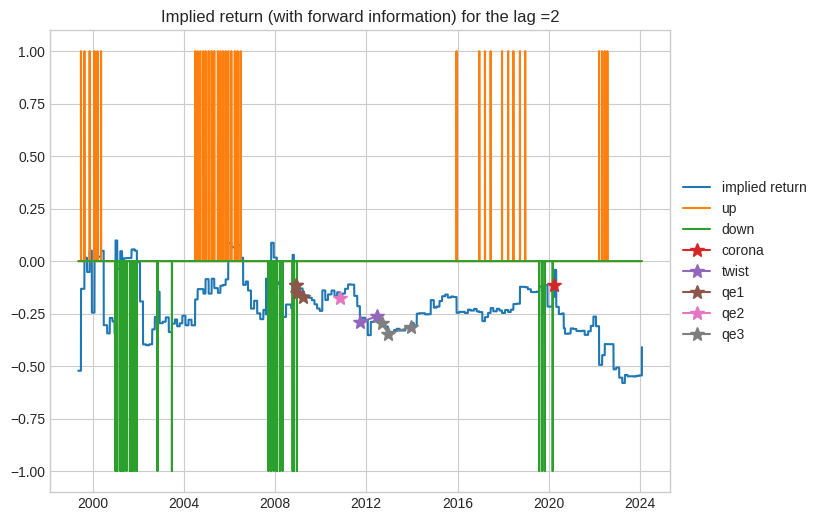

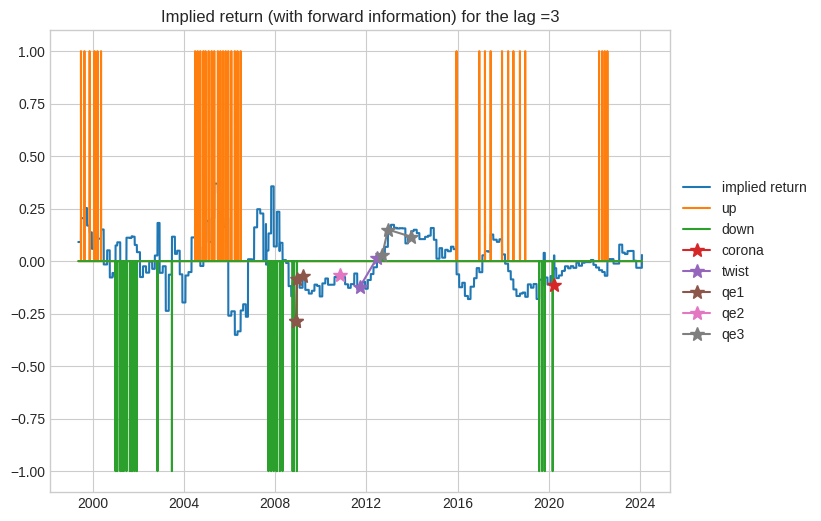

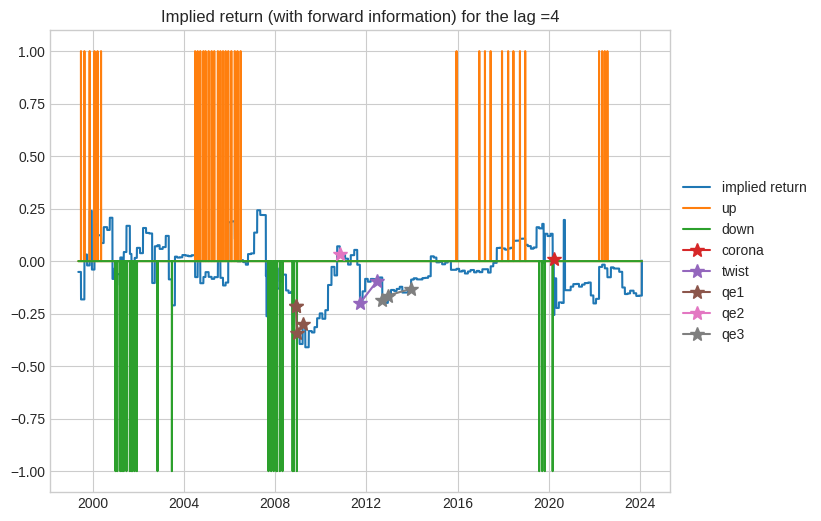

In [ ]:
def plot_coeff(statements,returns,lag):
  est = Pipeline([
      ("tfidf", TfidfVectorizer(
          vocabulary=None,
          ngram_range=(1, 3),
          max_features=500,
          stop_words="english",
          token_pattern=r"\b[a-zA-Z]{3,}\b",
      )),
      ("reg",  ElasticNet(alpha=0.0075))
  ])

  returns=returns[(returns['Close'] < -0.05) | (returns['Close'] > 0.05)]
  y=np.sign(returns["Close"].dropna())
  y_index=y.index
  statements_concerned=statements.loc[statements.index.isin(y_index)]


  X=statements_concerned['text']
  y=y.loc[X.index]

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

  est.fit(X_train, y_train)

  fig, ax = plt.subplots(figsize=(8, 6))
  pred_tfidf = (
      pd.Series(est.predict(statements["text"]), index=statements.index)
      .resample("B")
      .last()
      .ffill()
  )
  line(
      pred_tfidf.rename("implied rate")
      .to_frame()
      .join(
          pd.Series(1, index=fomc_change_up)
          .reindex(pred_tfidf.index)
          .fillna(0)
          .rename("up")
  ) .join(
          pd.Series(-1, index=fomc_change_dw)
          .reindex(pred_tfidf.index)
          .fillna(0)
          .rename("dw")
      ),
      sort=False,
      ax=ax,
      title="Implied return (with forward information) for the lag ="+f'{lag}',
  )
  cols = ["corona", "twist", "qe1", "qe2", "qe3"]
  for c in cols:
      ax.plot(pred_tfidf.loc[other[c]], marker="*", ms=10)
  ax.legend(
      ["implied return", "up", "down"] + cols, loc="center left", bbox_to_anchor=(1, 0.5)
  )

# VIZUALISATION FOR THE 5 day ahead
for i in range(1,5):
  ret_fomc=compute_lagged_return(vix_data,i)
  plot_coeff(statements,ret_fomc,i)

### Convergence of the model


We compute 5-fold cross validation for the convergence of the model

[ 40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57
  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75
  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93
  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111
 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129
 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147
 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165
 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183
 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  80  81  82  83  84  85  86  87  88  89  90  91  92  93
  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111
 112 113 114 115 116 117 118 119 120 121 122 123 124 125 1

In [ ]:
from sklearn.model_selection import KFold
skf = KFold(n_splits=5)
returns=compute_lagged_return(vix_data,1)

est = Pipeline([
    ("tfidf", TfidfVectorizer(
        vocabulary=None,
        ngram_range=(1, 3),
        max_features=300,
        stop_words="english",
        token_pattern=r"\b[a-zA-Z]{3,}\b",
    )),
    ("reg",  ElasticNet(alpha=0.008))
])


returns=returns[(returns['Close'] < -0.05) | (returns['Close'] > 0.05)]
y=np.sign(returns["Close"].dropna())
y_index=y.index
statements_concerned=statements.loc[statements.index.isin(y_index)]


X=statements_concerned['text']
y=y.loc[X.index]



result=[]
for train_index, test_index in skf.split(X, y):
  X_train, X_test, y_train, y_test = X.iloc[train_index],X.iloc[test_index],y.iloc[train_index],y.iloc[test_index]
  est.fit(X_train, y_train)
  y_pred = est.predict(X_test)
  results=pd.DataFrame(y_test)
  results['pred']=np.sign(y_pred).astype(int)
  result.append(results)

lag=1
final_results=pd.concat(result)
data=pd.merge(final_results,vix_data['Close'],left_index=True,right_index=True)
data=pd.merge(data,vix_data['Close'].shift(-lag),left_index=True,right_index=True)

data.columns=['Sign at t+'f'{lag}','Pred Sign at t+'+f'{lag}','Price at t','Price at t+'+f'{lag}']
data['return at date t+'+f'{lag}']=(data['Price at t+'+f'{lag}']-data['Price at t'])/data['Price at t']

data['P&L']=data['Pred Sign at t+'+f'{lag}']*data['return at date t+'+f'{lag}']

df_sharpe=pd.DataFrame(index=vix_data.index)#index=range(5000)
#df_sharpe['P&L']=data.reset_index(drop=True)['P&L']
df_sharpe['P&L']=data['P&L']
df_sharpe['P&L']=df_sharpe['P&L'].fillna(0)
sharpe=np.sqrt(252/lag)*df_sharpe['P&L'].mean()/df_sharpe['P&L'].std()
print(sharpe)


-0.04020558016790675


In [ ]:
accuracy_score(final_results['Close'],final_results['pred'])

0.46

In [ ]:
df_sharpe

,0,P&L
0,0,0.0
1,1,0.0
2,2,0.0
3,3,0.0
4,4,0.0
...,...,...
6305,6305,0.0
6306,6306,0.0
6307,6307,0.0
6308,6308,0.0
